## AdaLIPO Test Notebook

### Documentation 


AdaLIPO uses CM-AES as standard inner loop algorithm (guided random search) but Random Search is implemented as well.  
To use Random Search instead, set "use_cmaes" to False in the adalipo function.  

There are two implementations, a 1D and a nD version:
- 1D function: displays all calculated points on the Lipschitz function and the objective function
- nD function: shows the computation time (increase) over all the calculation steps


Test functions:
- sum of squares (minimum: 0)
- ackley (minimum: 0) 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler

import import_ipynb
import data_management as data_management
import cmaes as cmaes

### Loading data

In [2]:
images,labels = data_management.get_data(fn = "Input_Dataset/input_data.csv",samples=10) 
sc = StandardScaler()
images = sc.fit_transform(np.float64(images))

### Timer function

In [3]:
def timerfunc(func):
    """
    A timer decorator
    """
    def function_timer(*args, **kwargs):
        """
        A nested function for timing other functions
        """
        start = time.time()
        value = func(*args, **kwargs)
        end = time.time()
        runtime = np.float(end - start)
        msg = "The runtime for {func} took {time} seconds to complete"
        print(msg.format(func=func.__name__,
                         time=runtime))
        
        return value
    return function_timer

### Hyperparameters

In [4]:
#@timerfunc
def sum_of_squares_hp():
    return np.array([[-20,20],[-20,20],[-20,20],[-20,20],[-20,20]])


In [5]:
def ackley_hp(): # evaluation on hypercube
    return np.array([[-32.768,32.768],[-32.768,32.768]])

In [6]:
def oneD_hyperparameters():
    return np.array([[-20,20]])

### Objective Functions

In [7]:
#@timerfunc
def sum_of_squares(hyperparameters): # minimum: 0
    # 1D
    #return np.sum(x**2 for x in [hyperparameters])
    return np.sum([x**2 for x in hyperparameters])

In [8]:
def ackley(x): # minimum: 0
        arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))     
        arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
        return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e

In [9]:
def sum_of_squares_1D(hyperparameters): # minimum: 0
    return np.sum(x**2 for x in [hyperparameters])

### Optimizer

In [10]:
# Lipschitz function
def L(xp_t1,fx,X,k):
    L_xp_t1 = np.amax([fx[index] - k * np.linalg.norm((xp_t1 - X[index]), ord=2) 
                    for index in range(len(X))])
    return L_xp_t1

In [11]:
def meta_L(xp,fx,X,k):
    return np.array([L(xp_t1,fx,X,k) for xp_t1 in xp])

In [12]:
@timerfunc
def adaptive_lipo(n, t_max, hyperparameters, f):
    """
    Args:
        n: number of iterations
        hyperparameters: possible inputs of f (or bounds for hyperparameters?)
        f: objective function 
        p: probability of exploitation vs (1-p) probability of exploration
    Returns:
        The estimated value that maximizes f
    """

    use_cmaes = True
    
    # Initialization 
    min_bounds,max_bounds = np.array(hyperparameters).T
    x1 = np.array((np.random.uniform(low=min_bounds, high=max_bounds, size=len(hyperparameters)))) 

    
    X = [x1]
    fx = [f(x1)]
    k = [0]
    t = 0
    
    # Iterations
    overall_time = []
    overall_rs_time = []
    time_k_update = []
    while t < t_max: 
        start_time = time.time()
        
        r_val = []
        # sample from L(x)
        
        if use_cmaes:
            gen = cmaes.minimize(meta_L, hyperparameters, fx, X, k[t], number_samples=20)

            cmaes_time = []
            for i in range(n): # exit criterion? 
                start_time_rs = time.time()
                params,evaluation = next(gen)
                #print("Params: ", params, " Evaluation: ", evaluation)
                #print('len r_val: ', r_val)
#                 if len(r_val) > 0:
#                     if np.absolute(r_val[-1][1] - evaluation) < 0.001:
#                         print('finished after ', i, ' iterations')
#                         break
                r_val.append((params,evaluation))
            
                end_time_rs = time.time()
                time_needed_rs = end_time_rs - start_time_rs
                cmaes_time.append(time_needed_rs)
                overall_rs_time.append(time_needed_rs)
#                 print('time taken for cmaes loop', i, ' : ', time_needed_cmaes)
#                 plt.plot(np.arange(0,n),cmaes_time,marker='o', color='deepskyblue')
#                 plt.title('time for cmaes loop')
#                 plt.show()
        
        else:
            for a in range(0,n):
                start_time_rs = time.time()
                xp_t1 = np.array((np.random.uniform(low=min_bounds, high=max_bounds, size=len(hyperparameters)))) 

                # function to minimize
                L_xp_t1 = np.amax([fx[index] - k[t] * np.linalg.norm((xp_t1 - X[index]), ord=2)
                                   for index in range(len(X))])

                r_val.append((xp_t1,L_xp_t1))
                
                end_time_rs = time.time()
                time_needed_rs = end_time_rs - start_time_rs
                overall_rs_time.append(time_needed_rs)
                
        # sort after L_xp_t1 and choose the xp_t1 value with the smallest L value
        best_x = sorted(r_val,key=lambda x: x[1])[0][0]
        X.append(best_x) 
        
        
        if len(X) >= (t+2):
            #calc_f_time = time.time()
            fx.append(f(X[t+1]))
            #calc_f_time_end = time.time()
            #print("Time needed to calculate f for timestep", t, " : ", calc_f_time_end - calc_f_time)
            
            t += 1
            
            start_k_update = time.time()
            k.append(np.amax([(np.absolute(fx[i]-fx[j])/np.linalg.norm((X[i]-X[j]), ord=1)) #try: ord=2
                              for i in range(len(X)) for j in range(len(X)) if i != j 
                              and np.linalg.norm(X[i]-X[j], ord=1)!=0 
                             ])) # slope of all X's in X

            print("t:{}, k:{} with x:{} and obj:{}".format(t-1,k[t],X[t],fx[t]))
            end_time = time.time()
            time_loop = end_time - start_time
            time_k_update.append(end_time-start_k_update)
            overall_time.append(time_loop)
            #print('total time taken for loop ', t, ' : ', time_loop)
    if use_cmaes:            
        rs_time_reshaped = np.array(overall_rs_time).reshape((t_max,n))
        rs_time_sum = []
        for i in range(0,t_max):
            rs_time_sum.append(np.sum(rs_time_reshaped[i]))
    else:
        rs_time_sum = overall_rs_time
    print('rs time sum: ', np.sum(rs_time_sum))
    diff_time = [overall_time[i] - time_k_update[i] - rs_time_sum[i] for i in range(0,t_max)]
    
    plt.plot(np.arange(0,t_max),time_k_update,marker='o', color='crimson')
    plt.title("time needed for k update")
    plt.show()
    plt.plot(np.arange(0,len(overall_rs_time)),overall_rs_time,marker='o', color='lightgreen')
    plt.title("time needed for all cmaes/rs loops")
    plt.show()
    
    plt.plot(np.arange(0,t_max),overall_time,marker='o', color='darkorange')
    #plt.plot([0,t_max],[overall_time[0],overall_time[t_max-1]],linestyle='-',color='navy')
    plt.title("overall time needed for one loop at timestep t")
    plt.show()
    
    plt.plot(np.arange(0,t_max),diff_time,marker='o',color='purple')
    plt.title("overall time - k update time - (guided) random search time")
    plt.show()
    
    min_obj = np.argmin(fx)
    print('Minimum: ', np.amin(fx), ' for X: ', X[min_obj], ' with k: ', k[min_obj])
    
    return X[min_obj]

In [13]:
# 1D adalipo
def adaptive_lipo_1D(n, t_max, hyperparameters, f):
    """
    Args:
        n: number of iterations CMAES
        t_max: number of iterations AdaLIPO
        hyperparameters: possible inputs of f (or bounds for hyperparameters)
        f: objective function 
        p: probability of exploitation vs (1-p) probability of exploration
    Returns:
        The estimated value that maximizes f
    """

    use_cmaes = True
    
    # Initialization 
    min_bounds,max_bounds = np.array(hyperparameters).T
    print('min bounds: ', min_bounds, ' max bounds: ', max_bounds, ' len hp: ', len(hyperparameters))
    x1 = np.array((np.random.uniform(low=min_bounds, high=max_bounds, size=len(hyperparameters))))
    
    X = [x1]
    fx = [f(x1)]
    k = [0]
    t = 0
    L = [(x1,fx[0])]
    L_x = []
    
    # Outer Loop: AdaLIPO Iterations
    while t < t_max: 
        r_val = []
        
        # Inner Loop: sample from L(x) with cmaes or Random Search
        
        #cmaes
        if use_cmaes:
            gen = cmaes.minimize(meta_L, hyperparameters, fx, X, k[t],number_samples=10)

            for i in range(100): # TODO: exit criterion
                params,evaluation = next(gen)
                #print(evaluation)
                #print(params,evaluation)
                #print("Params: ", params, " Evaluation: ", evaluation)
                #print('len r_val: ', r_val)
    #             if len(r_val) > 0:
    #                 if np.absolute(r_val[-1][1] - evaluation) < 0.0000001:
    #                     print('finished after ', i, ' iterations')
    #                      break
                r_val.append((params,evaluation))
   
        # Random Search
        else:
            for a in range(0,n):
                xp_t1 = np.array((np.random.uniform(low=min_bounds, high=max_bounds, size=len(hyperparameters))))
                L_all_x = [fx[index] - k[t] * np.linalg.norm((xp_t1 - X[index]), ord=2)
                                   for index in range(len(X))]
                L_xp_t1 = np.amax(L_all_x)

                r_val.append((xp_t1,L_xp_t1))
            
#             # Visualization of calculated points of Lipschitz function at timestep t
#             for s in range(len(L_all_x)):
#                 plt.plot([xp_t1,X[s]],[L_all_x[s],fx[s]],linestyle='-', marker='o', color='darkorange')
            
#             sample_points = np.array((np.arange(-20, 20)))
#             function = np.sum(x**2 for x in [sample_points])
#             plt.plot(sample_points, function, linestyle='-', color='deepskyblue')
#             plt.plot(X, fx, linestyle='None', marker='o', color='yellow')
#             plt.plot(xp_t1, L_xp_t1, linestyle='None', marker='v', color='mediumblue')
#             plt.show()
            print('xp_t1: ', xp_t1, " L_xp_t1: ", L_xp_t1)


        # sort after L_xp_t1 and choose the xp_t1 value with the smallest L value
        best_x = sorted(r_val,key=lambda x: x[1])[0][0]
        X.append(best_x) 
        L.append((best_x,(sorted(r_val,key=lambda x: x[1])[0][1]))) 
        
          
        if len(X) >= (t+2):
            fx.append(f(X[t+1]))
            t += 1
            k.append(np.amax([(np.absolute(fx[i]-fx[j])/np.linalg.norm([(X[i]-X[j])], ord=1)) #try: ord=2
                              for i in range(len(X)) for j in range(len(X)) if i != j 
                              and np.linalg.norm([X[i]-X[j]], ord=1)!=0
                             ])) # slope of all X's in X

            print("t:{}, k:{} with x:{} and obj:{}".format(t-1,k[t],X[t],fx[t]))
    
    # Visualisation of Lipschitz function, actual function and calculated fx points
    # Note: + 2 indentions shows all the steps of the AdaLIPO algorithm
    sample_points = np.array((np.linspace(-20.,20.,num=100)))
    function = np.sum(x**2 for x in [sample_points])
    L_function = [np.amax([fx[index] - (k[t] * np.linalg.norm([(x - X[index])], ord=2))
                       for index in range(len(X))]) for x in sample_points]

    plt.plot(sample_points, function, linestyle='-', color='deepskyblue')
    plt.plot(sample_points, L_function, linestyle='-', color='purple')
    plt.plot(X, fx, linestyle='None', marker='o', color='yellow')
    plt.show()

                         
    min_obj = np.argmin(fx)
    print('Minimum: ', np.amin(fx), ' for X: ', X[min_obj], ' with k: ', k[min_obj])
    return X[min_obj]

### Test

min bounds:  [-20]  max bounds:  [20]  len hp:  1
t:0, k:17.61794924428822 with x:[0.73139741] and obj:[0.53494217]
t:1, k:20.731397412045126 with x:[20.] and obj:[400.]
t:2, k:20.731397412045126 with x:[-0.70137884] and obj:[0.49193227]


/home/jannine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


t:3, k:20.731397412045126 with x:[0.01397197] and obj:[0.00019522]
t:4, k:20.731397412045126 with x:[-1.41672965] and obj:[2.0071229]
t:5, k:20.731397412045126 with x:[-0.33184371] and obj:[0.11012025]
t:6, k:20.731397412045126 with x:[0.35978766] and obj:[0.12944716]
t:7, k:20.731397412045126 with x:[-1.02251086] and obj:[1.04552847]
t:8, k:20.731397412045126 with x:[-0.50740273] and obj:[0.25745753]
t:9, k:20.731397412045126 with x:[-1.81094843] and obj:[3.27953423]
t:10, k:20.731397412045126 with x:[0.18376252] and obj:[0.03376866]
t:11, k:20.731397412045126 with x:[-0.1562847] and obj:[0.02442491]
t:12, k:20.731397412045126 with x:[0.53581281] and obj:[0.28709536]
t:13, k:20.731397412045126 with x:[-0.8598627] and obj:[0.73936387]
t:14, k:20.731397412045126 with x:[-0.41606974] and obj:[0.17311403]
t:15, k:20.731397412045126 with x:[-0.07057199] and obj:[0.00498041]
t:16, k:20.731397412045126 with x:[-0.2419974] and obj:[0.05856274]
t:17, k:20.731397412045126 with x:[-1.19642851] a

/home/jannine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


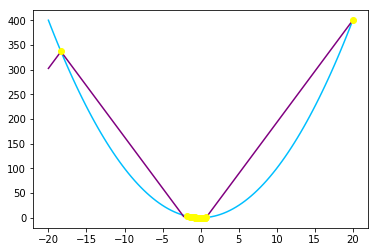

Minimum:  5.0294501607269715e-05  for X:  [-0.00709186]  with k:  20.731397412045126


array([-0.00709186])

In [14]:
# Test 1D with objective plots

hyperparameters = oneD_hyperparameters()
adaptive_lipo_1D(20,50,hyperparameters,sum_of_squares_1D)


# Test nD

# hyperparameters = sum_of_squares_hp()
# hyperparameters = ackley_hp()

# test objective functions: sum_of_squares, ackley
# adaptive_lipo(10,100,hyperparameters,ackley)